In [1]:
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import display
import os
import gc

In [2]:
print(os.getcwd())

model_repr = {
    "mab": "K-armed Bandit", 
    "ucbnaive": "Naive UCB Approach", 
    "ucbdelta": "UCB-delta Algorithm", 
    "ucbasym": "Asymptotically Optimal UCB", 
    "ucbmoss": "UCB MOSS Algorithm", 
    "thompson": "Thompson Sampling",
    "etc": "Explore-then-commit"
}

model_params = {
    "mab": "epsilon", 
    "ucbnaive": "c", 
    "ucbdelta": "delta", 
    "etc": "explore"  
}

/home/sungwoopark/rl-practice/bandit/MAB


In [3]:
def process(df:pd.DataFrame, no_param:bool):
    ## get cumulative reward
    cumsum_base = np.array([], dtype='float')
    for e in df['sim'].unique():
        rundf = df[df['sim'] == e]
        run_cumsum = np.cumsum(rundf['reward'])
        cumsum_base = np.append(cumsum_base, run_cumsum)
    df['cumulative_reward'] = cumsum_base
    
    ## check if the optimal arm is selected at each run
    df['chosen_optimal'] = (df['chosen_arm'] == df['optimal_arm']).astype('int')
    
    ## groupby
    if no_param:
        result = df[['step', 'reward', 'mean_reward', 'cumulative_reward', 'optimal_reward']].groupby(by='step').mean(numeric_only=False)
    else:
        result = df[['param', 'step', 'reward', 'mean_reward', 'cumulative_reward', 'optimal_reward']].groupby(by=['param', 'step']).mean(numeric_only=False)
    result.reset_index(drop=False, inplace=True)
    
    return result

In [4]:
def procedure(fname, no_param):
    with open(fname, "rb") as f:
        obj = pickle.load(f)
    
    processed = []
    for df in tqdm(obj):
        processed.append(process(df, no_param))
    
    del obj
    gc.collect()
    return processed

In [5]:
def getregret(dfs:list):
    for item in dfs:
        item['rnd_regret'] = np.cumsum(item['optimal_reward'] - item['reward'])
        item['regret'] = np.cumsum(item['optimal_reward'] - item['mean_reward'])        

In [6]:
def getlabel(colname:str):
    split = colname.split('_')
    split[0] = split[0][0].upper() + split[0][1:]
    label = ' '.join(split)
    return label

In [7]:
def plot_results(dfs, model, arm, columns='regret', figsize=(6, 4), singleplot=False, title=None):
    ylabel = getlabel(columns)
    if singleplot:
        plt.figure(figsize=figsize)
    max_regret = 0
    for item in dfs:
        if model in ["thompson", "ucbasym", "ucbmoss"]:
            label = f"{model_repr[model]}"
        else:
            label = f"{model_params[model]}={item['param'].iloc[0]}"
        plt.plot(item[columns], label=label)
        if max_regret < item[columns].max():
            max_regret = item[columns].max()
#     xpoints = plt.xlim()
    plt.plot(plt.xlim(), plt.ylim(), color='red', linestyle=':')
    plt.legend()
    plt.grid(True)
    plt.xlabel("Step")
    plt.ylabel(ylabel)
    if title:
        plt.title(f"{title} {model_repr[model]} {ylabel} - {arm} Arm")
    else:
        plt.title(f"{model_repr[model]} {ylabel} - {arm} Arm")
    
#     plt.tight_layout()
#     plt.show()

In [8]:
def summary(dfs, model, column, greedy, is_optimistic=False, is_regret=False):
    if is_optimistic:
        flag = "Optimistic "
    else:
        flag = ""
    
    means = [item[column].mean() for item in dfs]
    if not is_regret:
        arg = np.argmax(means)
    else:
        arg = np.argmin(means)

    if greedy:
        label = f"{flag}{model_repr[model]}, greedy"
        arg = 0
    else:
        best_param = dfs[arg]['param'].iloc[0]
        label = f"{flag}{model_repr[model]}, {model_params[model]}={best_param}"
    
    return arg, label

# Easy Bandit

In [9]:
os.chdir("./definite")
!ls

eGreedyMAB_BernoulliArm_0.5_Naive_results.pkl
eGreedyMAB_BernoulliArm_0.5_Optimistic_results.pkl
eGreedyMAB_BernoulliArm_1.0_Naive_results.pkl
eGreedyMAB_BernoulliArm_1.0_Optimistic_results.pkl
eGreedyMAB_GaussianArm_0.5_Naive_results.pkl
eGreedyMAB_GaussianArm_0.5_Optimistic_results.pkl
eGreedyMAB_GaussianArm_1.0_Naive_results.pkl
eGreedyMAB_GaussianArm_1.0_Optimistic_results.pkl
ETC_BernoulliArm_1.0_Naive_results.pkl
ETC_GaussianArm_1.0_Naive_results.pkl
ThompsonSampling_BernoulliArm_1.0_Naive_results.pkl
ThompsonSampling_GaussianArm_1.0_Naive_results.pkl
UCBAsymptotic_BernoulliArm_1.0_Naive_results.pkl
UCBAsymptotic_GaussianArm_1.0_Naive_results.pkl
UCBDelta_BernoulliArm_1.0_Naive_results.pkl
UCBDelta_GaussianArm_1.0_Naive_results.pkl
UCBMOSS_BernoulliArm_1.0_Naive_results.pkl
UCBMOSS_GaussianArm_1.0_Naive_results.pkl
UCBNaive_BernoulliArm_1.0_Naive_results.pkl
UCBNaive_GaussianArm_1.0_Naive_results.pkl


## Multi-Armed Bandit

### $\alpha$=1

In [10]:
mab_bern_1 = procedure(fname="./eGreedyMAB_BernoulliArm_1.0_Naive_results.pkl", no_param=False)
mab_gaus_1 = procedure(fname="./eGreedyMAB_GaussianArm_1.0_Naive_results.pkl", no_param=False)

100%|██████████████████████████████████████████████████████████████████████████| 6/6 [00:30<00:00,  5.16s/it]


In [11]:
getregret(mab_bern_1)
getregret(mab_gaus_1)

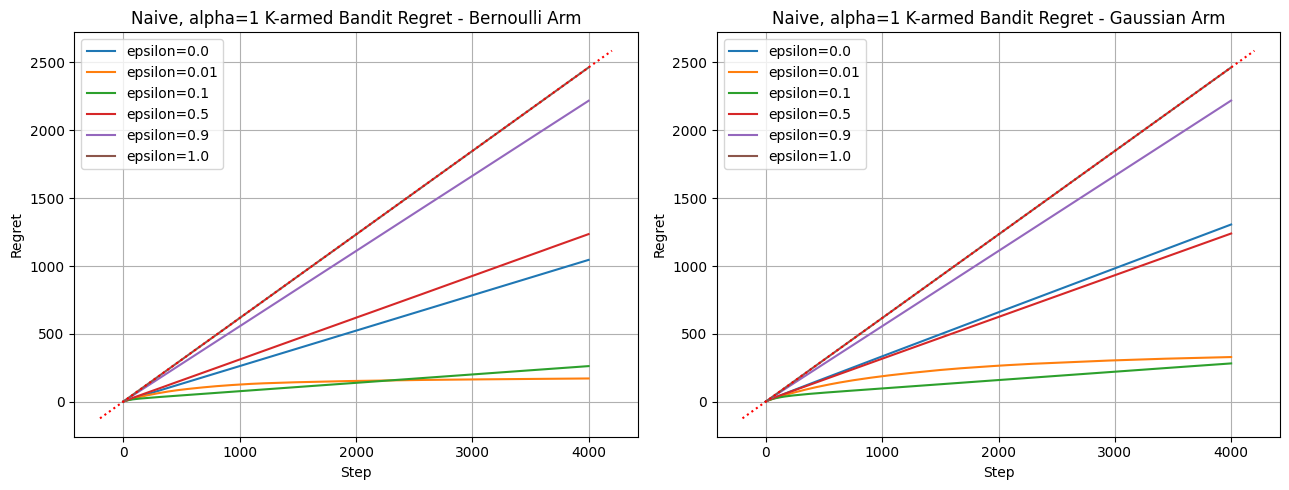

In [12]:
plt.figure(figsize=(13, 5))

plt.subplot(121)
plot_results(mab_bern_1, model="mab", arm="Bernoulli", columns='regret', title="Naive, alpha=1")

plt.subplot(122)
plot_results(mab_gaus_1, model="mab", arm="Gaussian", columns='regret', title="Naive, alpha=1")

plt.tight_layout()
plt.show()

### $\alpha$=0.5

In [13]:
mab_bern_half = procedure(fname="./eGreedyMAB_BernoulliArm_0.5_Naive_results.pkl", no_param=False)
mab_gaus_half = procedure(fname="./eGreedyMAB_GaussianArm_0.5_Naive_results.pkl", no_param=False)

100%|██████████████████████████████████████████████████████████████████████████| 6/6 [00:30<00:00,  5.13s/it]


In [14]:
getregret(mab_bern_half)
getregret(mab_gaus_half)

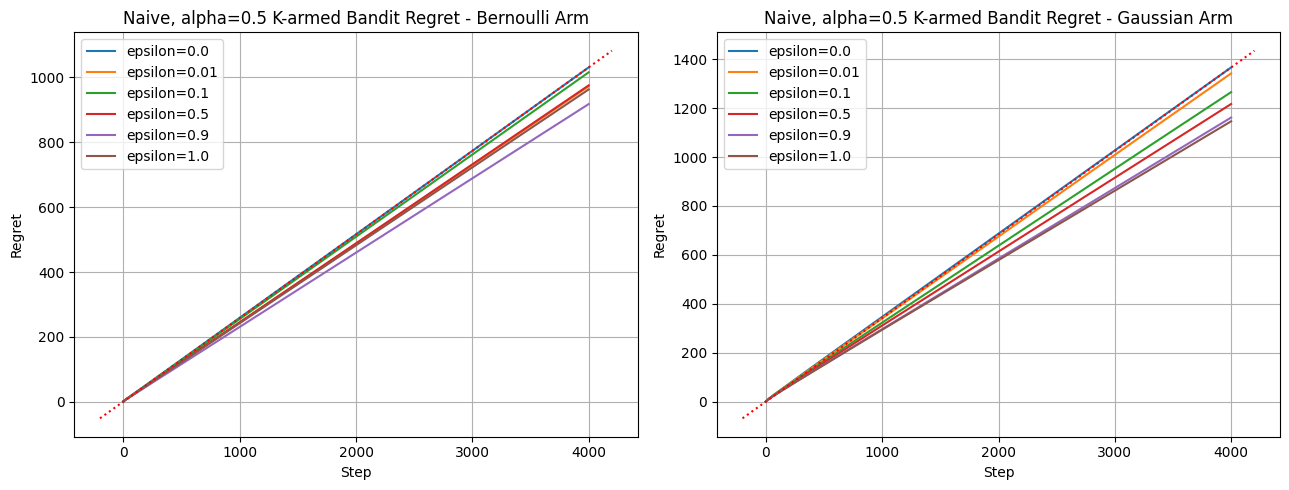

In [15]:
plt.figure(figsize=(13, 5))

plt.subplot(121)
plot_results(mab_bern_half, model="mab", arm="Bernoulli", columns='regret', title="Naive, alpha=0.5")

plt.subplot(122)
plot_results(mab_gaus_half, model="mab", arm="Gaussian", columns='regret', title="Naive, alpha=0.5")

plt.tight_layout()
plt.show()

## Optimistic Multi-Armed Bandit

### $\alpha$=1

In [16]:
mab_opt_bern_1 = procedure(fname="./eGreedyMAB_BernoulliArm_1.0_Optimistic_results.pkl", no_param=False)
mab_opt_gaus_1 = procedure(fname="./eGreedyMAB_GaussianArm_1.0_Optimistic_results.pkl", no_param=False)

getregret(mab_opt_bern_1)
getregret(mab_opt_gaus_1)

100%|██████████████████████████████████████████████████████████████████████████| 6/6 [00:30<00:00,  5.11s/it]


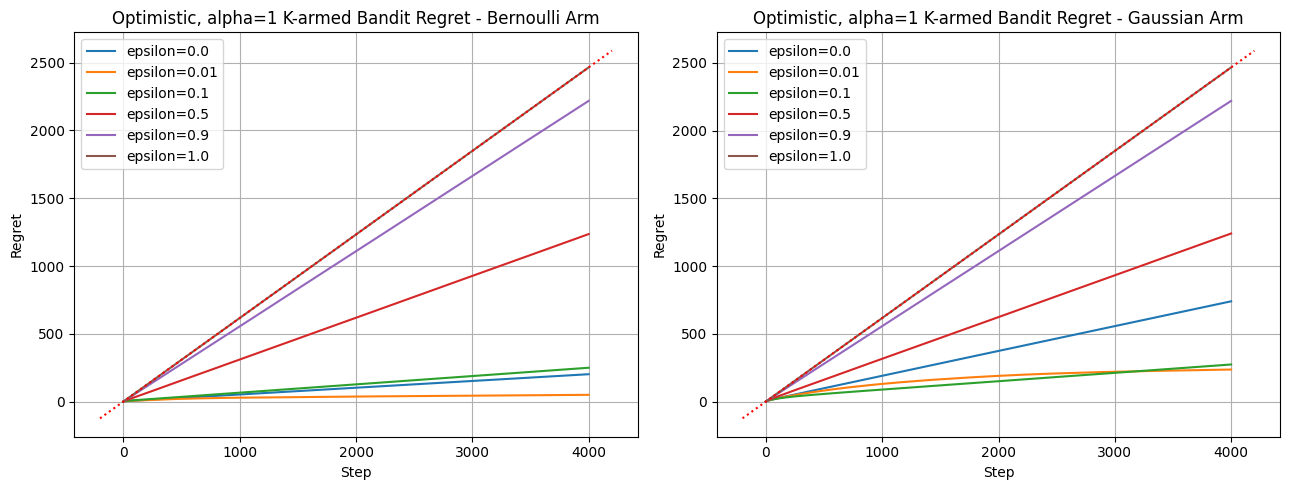

In [17]:
plt.figure(figsize=(13, 5))

plt.subplot(121)
plot_results(mab_opt_bern_1, model="mab", arm="Bernoulli", columns='regret', title="Optimistic, alpha=1")

plt.subplot(122)
plot_results(mab_opt_gaus_1, model="mab", arm="Gaussian", columns='regret', title="Optimistic, alpha=1")

plt.tight_layout()
plt.show()

### $\alpha$=0.5

In [18]:
mab_opt_bern_half = procedure(fname="./eGreedyMAB_BernoulliArm_0.5_Optimistic_results.pkl", no_param=False)
mab_opt_gaus_half = procedure(fname="./eGreedyMAB_GaussianArm_0.5_Optimistic_results.pkl", no_param=False)

getregret(mab_opt_bern_half)
getregret(mab_opt_gaus_half)

100%|██████████████████████████████████████████████████████████████████████████| 6/6 [00:30<00:00,  5.10s/it]


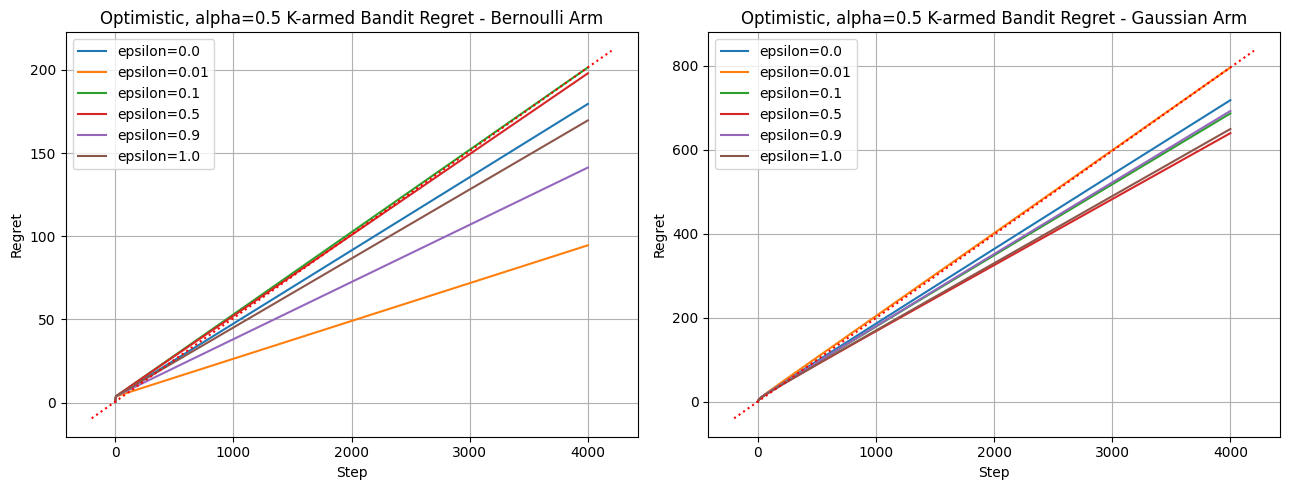

In [19]:
plt.figure(figsize=(13, 5))

plt.subplot(121)
plot_results(mab_opt_bern_half, model="mab", arm="Bernoulli", columns='regret', title="Optimistic, alpha=0.5")

plt.subplot(122)
plot_results(mab_opt_gaus_half, model="mab", arm="Gaussian", columns='regret', title="Optimistic, alpha=0.5")

plt.tight_layout()
plt.show()

## Naive vs Optimistic

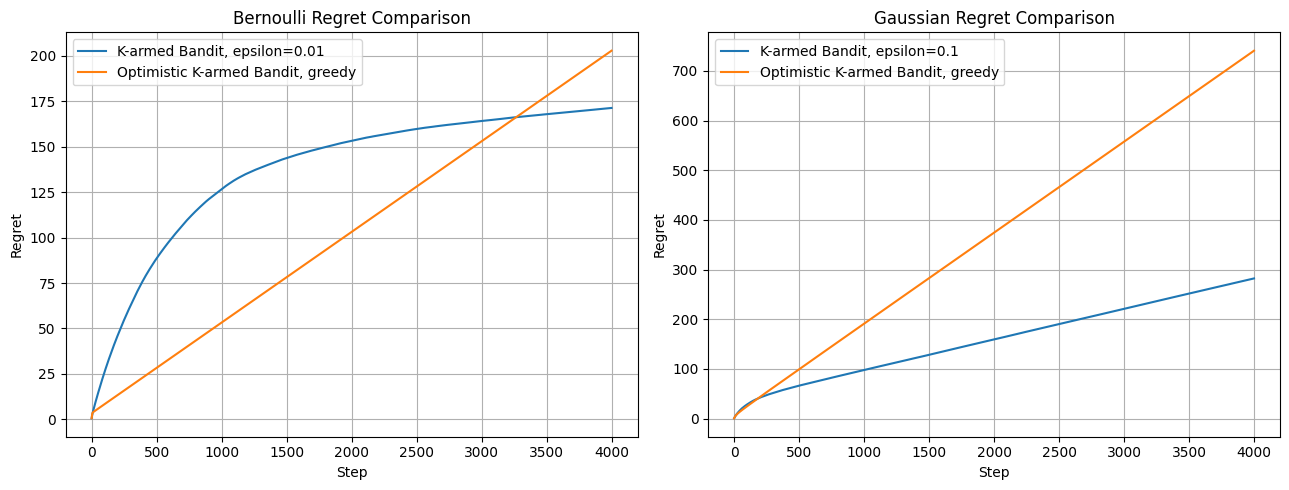

In [20]:
figsize = (13, 5)

model1, model2 = "mab", "mab"

column = 'regret'
ylabel = getlabel(column)

argmin1_col1, label1_col1 = summary(mab_bern_1, model1, column, greedy=False, is_optimistic=False, is_regret=True)
argmin2_col1, label2_col1 = summary(mab_opt_bern_1, model2, column, greedy=True, is_optimistic=True, is_regret=True)

argmin1_col2, label1_col2 = summary(mab_gaus_1, model1, column, greedy=False, is_optimistic=False, is_regret=True)
argmin2_col2, label2_col2 = summary(mab_opt_gaus_1, model2, column, greedy=True, is_optimistic=True, is_regret=True)

plt.figure(figsize=figsize)

plt.subplot(121)
plt.plot(mab_bern_1[argmin1_col1][column], label=label1_col1)
plt.plot(mab_opt_bern_1[argmin2_col1][column], label=label2_col1)
plt.grid(True)
plt.xlabel("Step")
plt.ylabel(ylabel)
plt.legend()
plt.title(f"Bernoulli {ylabel} Comparison")

plt.subplot(122)
plt.plot(mab_gaus_1[argmin1_col2][column], label=label1_col2)
plt.plot(mab_opt_gaus_1[argmin2_col2][column], label=label2_col2)
plt.grid(True)
plt.xlabel("Step")
plt.ylabel(ylabel)
plt.legend()
plt.title(f"Gaussian {ylabel} Comparison")

plt.tight_layout()
plt.show()

## Explore-then-Commit

In [21]:
etc_bern_1 = procedure(fname="./ETC_BernoulliArm_1.0_Naive_results.pkl", no_param=False)
etc_gaus_1 = procedure(fname="./ETC_GaussianArm_1.0_Naive_results.pkl", no_param=False)

getregret(etc_bern_1)
getregret(etc_gaus_1)

100%|██████████████████████████████████████████████████████████████████████████| 4/4 [00:20<00:00,  5.15s/it]


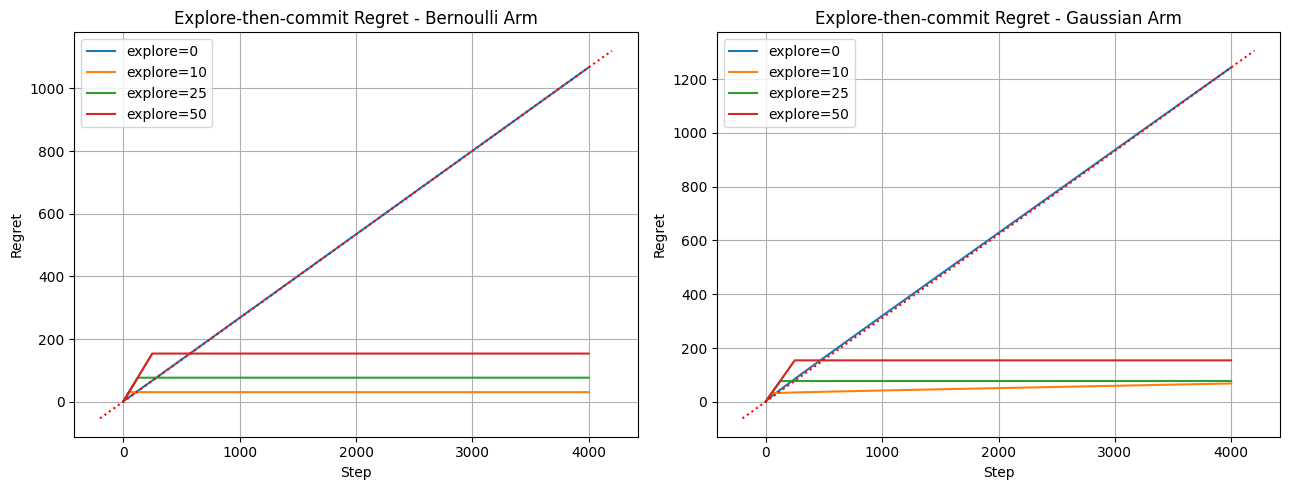

In [22]:
plt.figure(figsize=(13, 5))

plt.subplot(121)
plot_results(etc_bern_1, model="etc", arm="Bernoulli", columns='regret')

plt.subplot(122)
plot_results(etc_gaus_1, model="etc", arm="Gaussian", columns='regret')

plt.tight_layout()
plt.show()

## Thompson Sampling

In [23]:
ts_bern = procedure(fname="./ThompsonSampling_BernoulliArm_1.0_Naive_results.pkl", no_param=True)
ts_gaus = procedure(fname="./ThompsonSampling_GaussianArm_1.0_Naive_results.pkl", no_param=True)

getregret(ts_bern)
getregret(ts_gaus)

100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.22s/it]


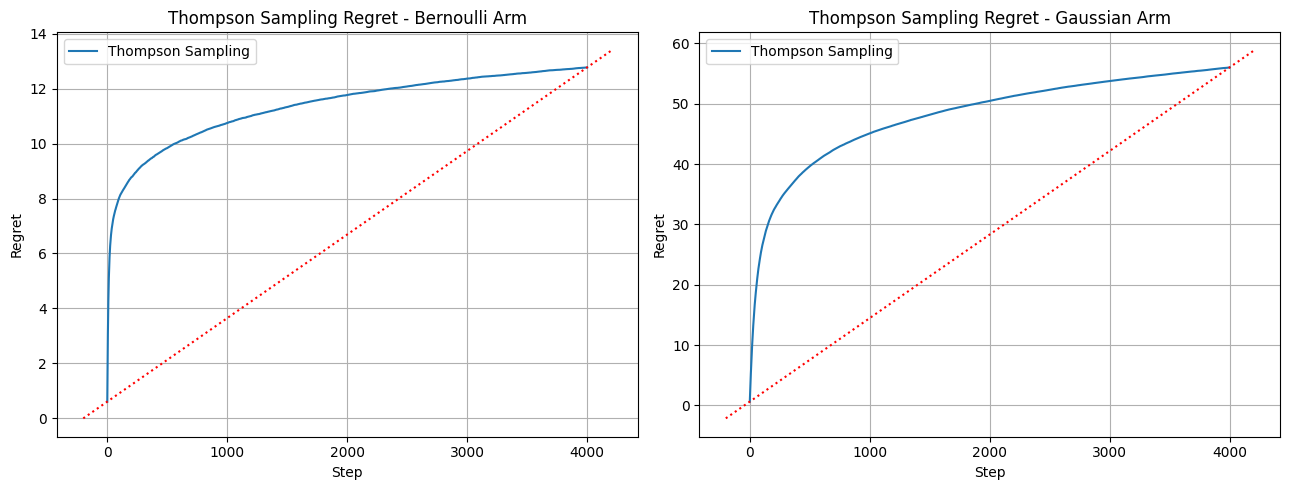

In [24]:
plt.figure(figsize=(13, 5))

plt.subplot(121)
plot_results(ts_bern, model="thompson", arm="Bernoulli", columns='regret')

plt.subplot(122)
plot_results(ts_gaus, model="thompson", arm="Gaussian", columns='regret')

plt.tight_layout()
plt.show()

## UCB

### Naive

In [25]:
ucbnaive_bern_1 = procedure(fname="./UCBNaive_BernoulliArm_1.0_Naive_results.pkl", no_param=False)
ucbnaive_gaus_1 = procedure(fname="./UCBNaive_GaussianArm_1.0_Naive_results.pkl", no_param=False)

getregret(ucbnaive_bern_1)
getregret(ucbnaive_gaus_1)

100%|██████████████████████████████████████████████████████████████████████████| 5/5 [00:27<00:00,  5.44s/it]


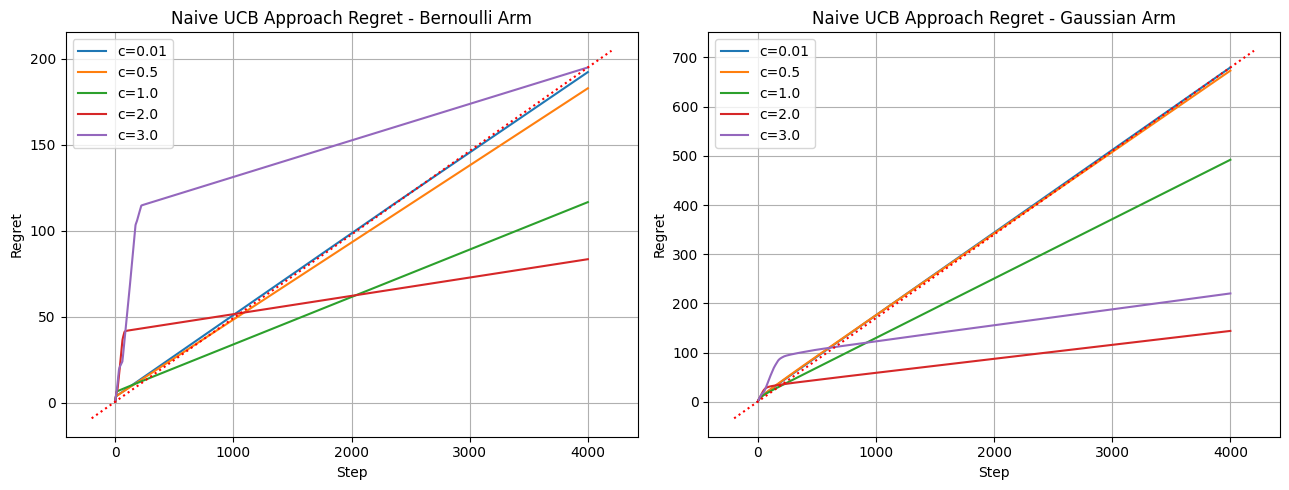

In [26]:
plt.figure(figsize=(13, 5))

plt.subplot(121)
plot_results(ucbnaive_bern_1, model="ucbnaive", arm="Bernoulli", columns='regret')

plt.subplot(122)
plot_results(ucbnaive_gaus_1, model="ucbnaive", arm="Gaussian", columns='regret')

plt.tight_layout()
plt.show()

### Delta

In [27]:
ucbdelta_bern_1 = procedure(fname="./UCBDelta_BernoulliArm_1.0_Naive_results.pkl", no_param=False)
ucbdelta_gaus_1 = procedure(fname="./UCBDelta_GaussianArm_1.0_Naive_results.pkl", no_param=False)

getregret(ucbdelta_bern_1)
getregret(ucbdelta_gaus_1)

100%|██████████████████████████████████████████████████████████████████████████| 6/6 [00:36<00:00,  6.00s/it]


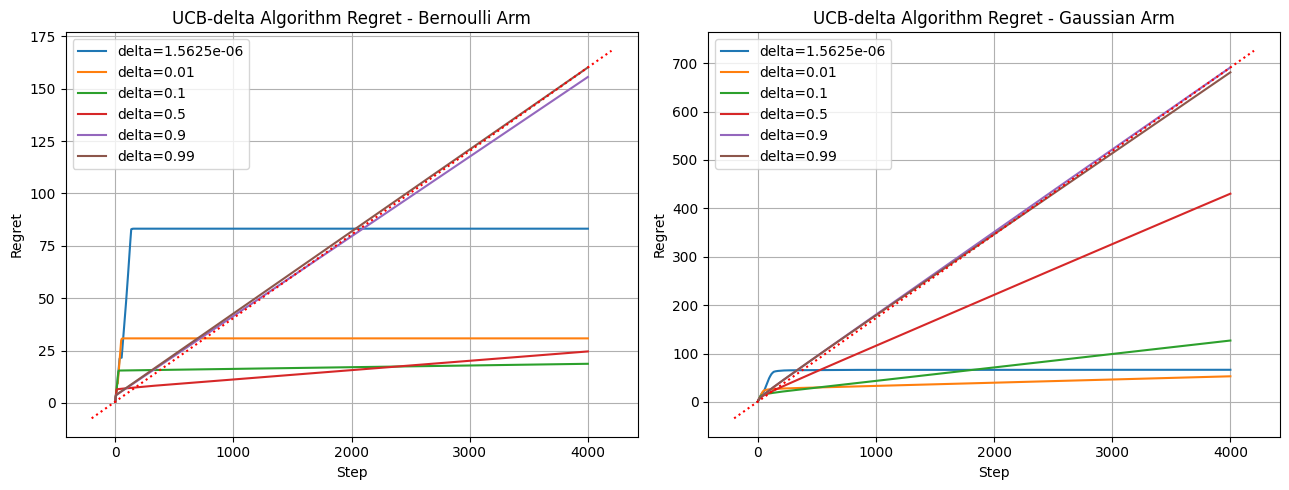

In [28]:
plt.figure(figsize=(13, 5))

plt.subplot(121)
plot_results(ucbdelta_bern_1, model="ucbdelta", arm="Bernoulli", columns='regret')

plt.subplot(122)
plot_results(ucbdelta_gaus_1, model="ucbdelta", arm="Gaussian", columns='regret')

plt.tight_layout()
plt.show()

### Asymptotically Optimal

In [29]:
ucbasym_bern_1 = procedure(fname="./UCBAsymptotic_BernoulliArm_1.0_Naive_results.pkl", no_param=True)
ucbasym_gaus_1 = procedure(fname="./UCBAsymptotic_GaussianArm_1.0_Naive_results.pkl", no_param=True)

getregret(ucbasym_bern_1)
getregret(ucbasym_gaus_1)

100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.18s/it]


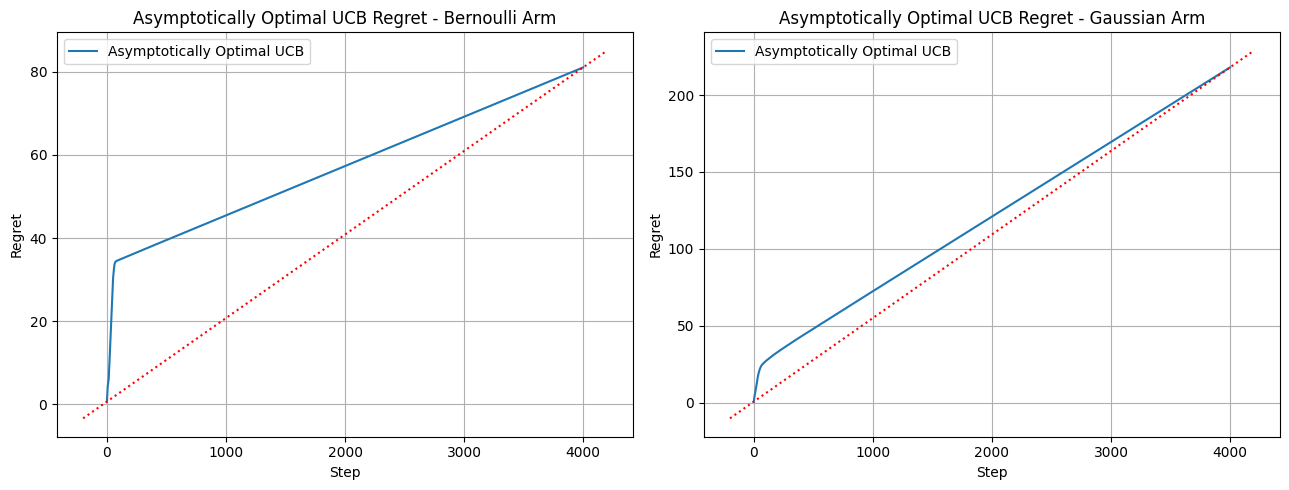

In [30]:
plt.figure(figsize=(13, 5))

plt.subplot(121)
plot_results(ucbasym_bern_1, model="ucbasym", arm="Bernoulli", columns='regret')

plt.subplot(122)
plot_results(ucbasym_gaus_1, model="ucbasym", arm="Gaussian", columns='regret')

plt.tight_layout()
plt.show()

### MOSS

In [31]:
ucbmoss_bern_1 = procedure(fname="./UCBMOSS_BernoulliArm_1.0_Naive_results.pkl", no_param=True)
ucbmoss_gaus_1 = procedure(fname="./UCBMOSS_GaussianArm_1.0_Naive_results.pkl", no_param=True)

getregret(ucbmoss_bern_1)
getregret(ucbmoss_gaus_1)

100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.19s/it]


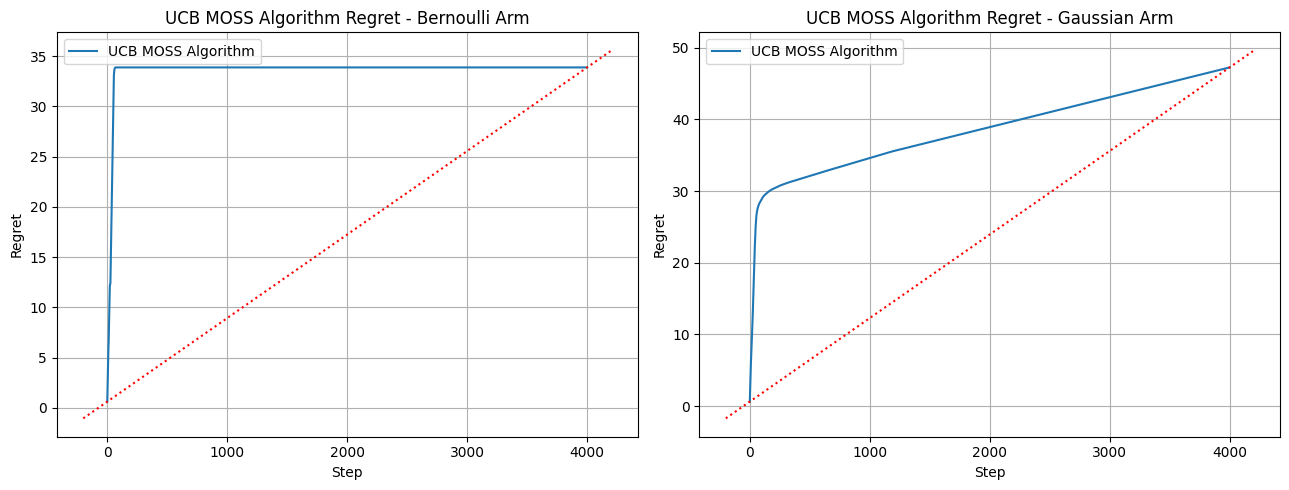

In [32]:
plt.figure(figsize=(13, 5))

plt.subplot(121)
plot_results(ucbmoss_bern_1, model="ucbmoss", arm="Bernoulli", columns='regret')

plt.subplot(122)
plot_results(ucbmoss_gaus_1, model="ucbmoss", arm="Gaussian", columns='regret')

plt.tight_layout()
plt.show()

### UCB Comparison

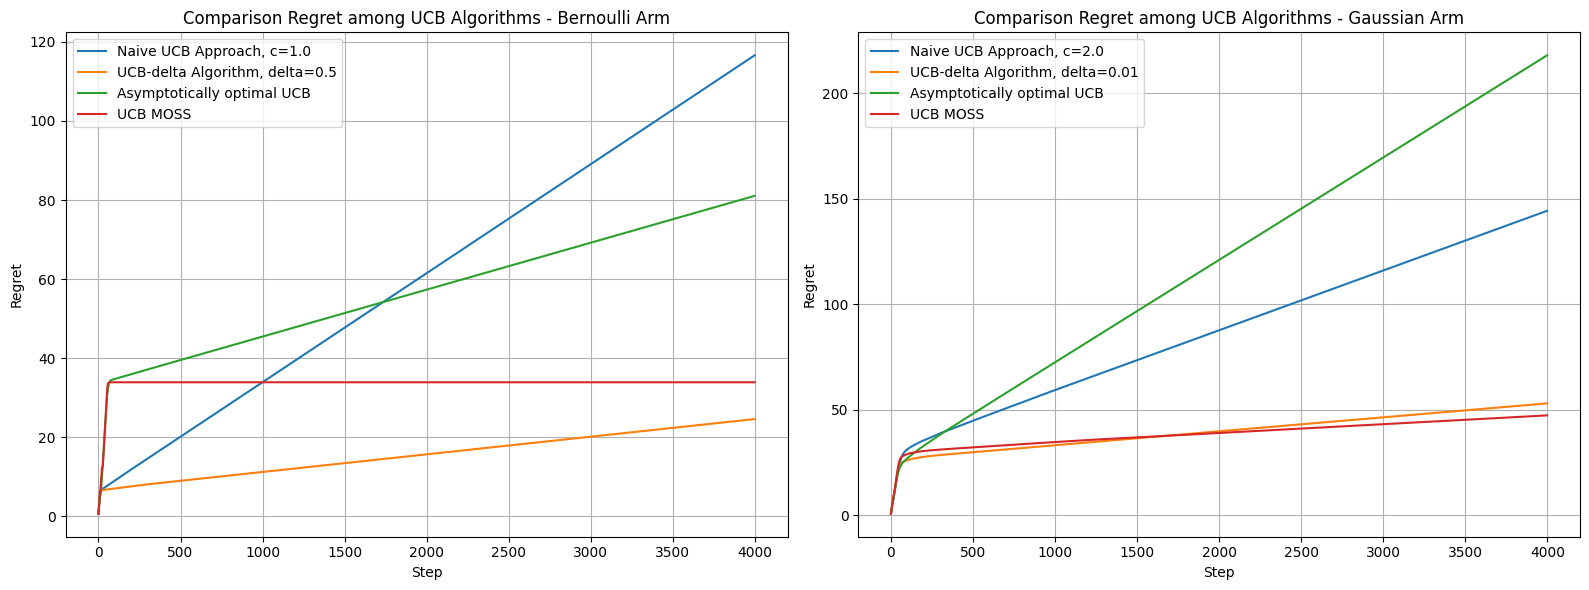

In [33]:
column = 'regret'
label = getlabel(column)

## find the best confidence term - naive approach
argmin_bern, label_bern = summary(ucbnaive_bern_1, "ucbnaive", column, greedy=False, is_optimistic=False, is_regret=True)
argmin_gaus, label_gaus = summary(ucbnaive_gaus_1, "ucbnaive", column, greedy=False, is_optimistic=False, is_regret=True)

## find the best delta
argmin_bern_delta, label_bern_delta = summary(ucbdelta_bern_1, "ucbdelta", column, greedy=False, is_optimistic=False, is_regret=True)
argmin_gaus_delta, label_gaus_delta = summary(ucbdelta_gaus_1, "ucbdelta", column, greedy=False, is_optimistic=False, is_regret=True)

naive_best_epsilon_bern = ucbnaive_bern_1[argmin_bern]['param'].iloc[0]
delta_best_epsilon_bern = ucbdelta_bern_1[argmin_bern_delta]['param'].iloc[0]

naive_best_epsilon_gaus = ucbnaive_gaus_1[argmin_gaus]['param'].iloc[0]
delta_best_epsilon_gaus = ucbdelta_gaus_1[argmin_gaus_delta]['param'].iloc[0]

figsize=(16, 6)
plt.figure(figsize=figsize)

plt.subplot(121)
plt.plot(ucbnaive_bern_1[argmin_bern][column], label=label_bern)
plt.plot(ucbdelta_bern_1[argmin_bern_delta][column], label=label_bern_delta)
plt.plot(ucbasym_bern_1[0][column], label=f"Asymptotically optimal UCB")
plt.plot(ucbmoss_bern_1[0][column], label=f"UCB MOSS")
plt.grid(True)
plt.xlabel("Step")
plt.ylabel(label)
plt.legend()
plt.title(f"Comparison {label} among UCB Algorithms - Bernoulli Arm")

plt.subplot(122)
plt.plot(ucbnaive_gaus_1[argmin_gaus][column], label=label_gaus)
plt.plot(ucbdelta_gaus_1[argmin_gaus_delta][column], label=label_gaus_delta)
plt.plot(ucbasym_gaus_1[0][column], label=f"Asymptotically optimal UCB")
plt.plot(ucbmoss_gaus_1[0][column], label=f"UCB MOSS")
plt.grid(True)
plt.xlabel("Step")
plt.ylabel(label)
plt.legend()
plt.title(f"Comparison {label} among UCB Algorithms - Gaussian Arm")

plt.tight_layout()
plt.show()

## Comparison Among Algorithms

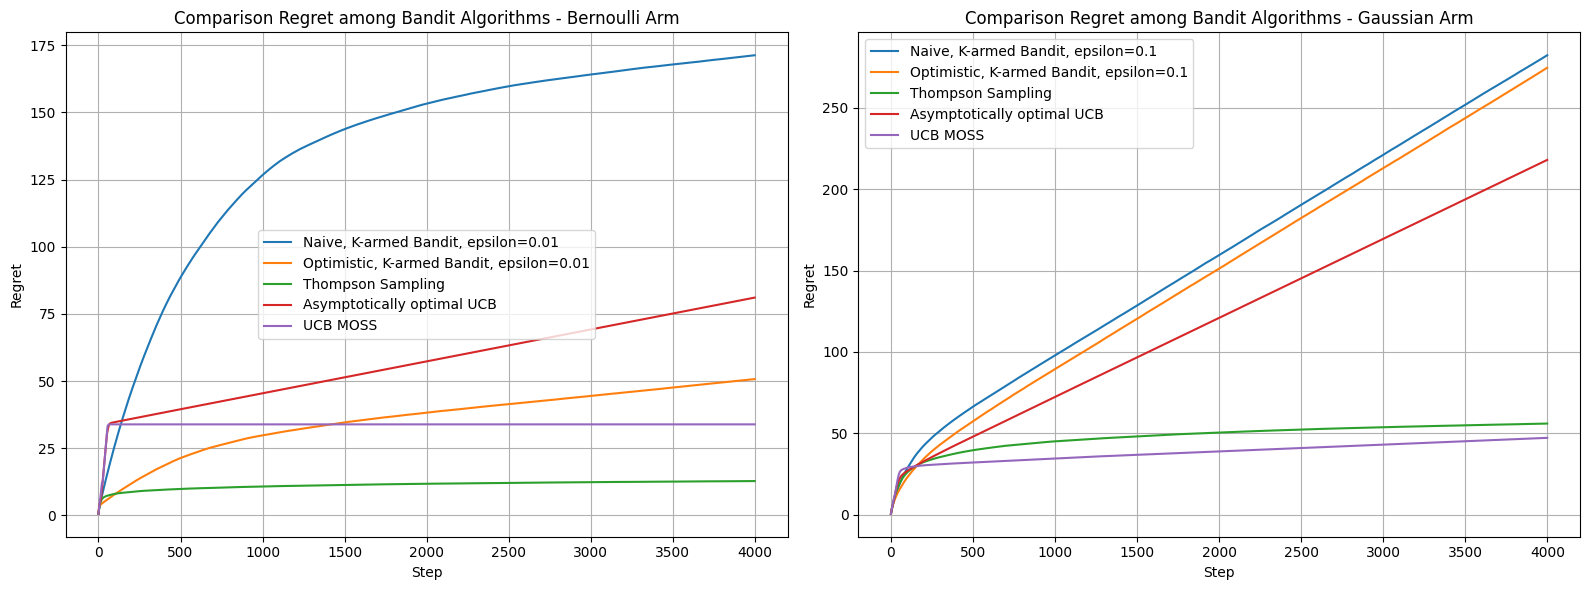

In [34]:
column = 'regret'
label = getlabel(column)

## find the best epsilon - naive approach
naive_mab_argmin_bern, naive_mab_label_bern = summary(mab_bern_1, "mab", column, greedy=False, is_optimistic=False, is_regret=True)
naive_mab_argmin_gaus, naive_mab_label_gaus = summary(mab_gaus_1, "mab", column, greedy=False, is_optimistic=False, is_regret=True)

## find the best epsilon - optimistic approach
opt_mab_argmin_bern, opt_mab_label_bern = summary(mab_opt_bern_1, "mab", column, greedy=False, is_optimistic=False, is_regret=True)
opt_mab_argmin_gaus, opt_mab_label_gaus = summary(mab_opt_gaus_1, "mab", column, greedy=False, is_optimistic=False, is_regret=True)

naive_best_epsilon_bern = mab_bern_1[naive_mab_argmin_bern]['param'].iloc[0]
naive_best_epsilon_gaus = mab_gaus_1[naive_mab_argmin_gaus]['param'].iloc[0]

opt_best_epsilon_bern = mab_opt_bern_1[opt_mab_argmin_bern]['param'].iloc[0]
opt_best_epsilon_gaus = mab_opt_gaus_1[opt_mab_argmin_gaus]['param'].iloc[0]

figsize=(16, 6)
plt.figure(figsize=figsize)

plt.subplot(121)
plt.plot(mab_bern_1[naive_mab_argmin_bern][column], label=f"Naive, {naive_mab_label_bern}")
plt.plot(mab_opt_bern_1[opt_mab_argmin_bern][column], label=f"Optimistic, {opt_mab_label_bern}")
plt.plot(ts_bern[0][column], label=f"Thompson Sampling")
plt.plot(ucbasym_bern_1[0][column], label=f"Asymptotically optimal UCB")
plt.plot(ucbmoss_bern_1[0][column], label=f"UCB MOSS")
plt.grid(True)
plt.xlabel("Step")
plt.ylabel(label)
plt.legend()
plt.title(f"Comparison {label} among Bandit Algorithms - Bernoulli Arm")

plt.subplot(122)
plt.plot(mab_gaus_1[naive_mab_argmin_gaus][column], label=f"Naive, {naive_mab_label_gaus}")
plt.plot(mab_opt_gaus_1[opt_mab_argmin_gaus][column], label=f"Optimistic, {opt_mab_label_gaus}")
plt.plot(ts_gaus[0][column], label=f"Thompson Sampling")
plt.plot(ucbasym_gaus_1[0][column], label=f"Asymptotically optimal UCB")
plt.plot(ucbmoss_gaus_1[0][column], label=f"UCB MOSS")
plt.grid(True)
plt.xlabel("Step")
plt.ylabel(label)
plt.legend()
plt.title(f"Comparison {label} among Bandit Algorithms - Gaussian Arm")

plt.tight_layout()
plt.show()

# Hard Bandit

In [35]:
os.chdir("../indefinite")
!ls

eGreedyMAB_BernoulliArm_0.5_Naive_results.pkl
eGreedyMAB_BernoulliArm_0.5_Optimistic_results.pkl
eGreedyMAB_BernoulliArm_1.0_Naive_results.pkl
eGreedyMAB_BernoulliArm_1.0_Optimistic_results.pkl
eGreedyMAB_GaussianArm_0.5_Naive_results.pkl
eGreedyMAB_GaussianArm_0.5_Optimistic_results.pkl
eGreedyMAB_GaussianArm_1.0_Naive_results.pkl
eGreedyMAB_GaussianArm_1.0_Optimistic_results.pkl
ETC_BernoulliArm_1.0_Naive_results.pkl
ETC_GaussianArm_1.0_Naive_results.pkl
ThompsonSampling_BernoulliArm_1.0_Naive_results.pkl
ThompsonSampling_GaussianArm_1.0_Naive_results.pkl
UCBAsymptotic_BernoulliArm_1.0_Naive_results.pkl
UCBAsymptotic_GaussianArm_1.0_Naive_results.pkl
UCBDelta_BernoulliArm_1.0_Naive_results.pkl
UCBDelta_GaussianArm_1.0_Naive_results.pkl
UCBMOSS_BernoulliArm_1.0_Naive_results.pkl
UCBMOSS_GaussianArm_1.0_Naive_results.pkl
UCBNaive_BernoulliArm_1.0_Naive_results.pkl
UCBNaive_GaussianArm_1.0_Naive_results.pkl


## Multi-Armed Bandit

### $\alpha$=1

In [36]:
mab_bern_1 = procedure(fname="./eGreedyMAB_BernoulliArm_1.0_Naive_results.pkl", no_param=False)
mab_gaus_1 = procedure(fname="./eGreedyMAB_GaussianArm_1.0_Naive_results.pkl", no_param=False)

100%|██████████████████████████████████████████████████████████████████████████| 6/6 [00:31<00:00,  5.29s/it]


In [37]:
getregret(mab_bern_1)
getregret(mab_gaus_1)

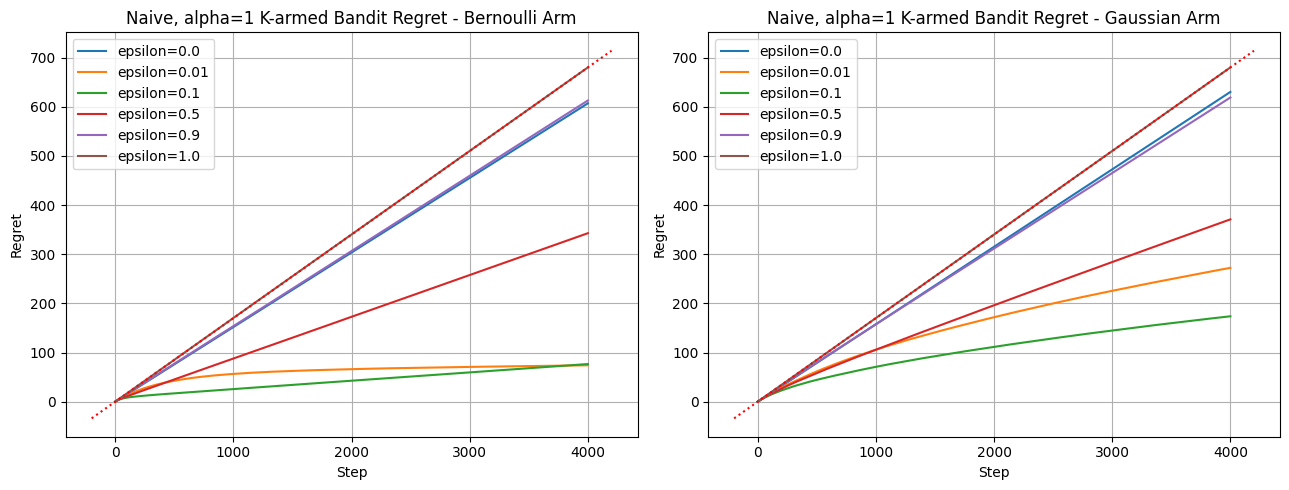

In [38]:
plt.figure(figsize=(13, 5))

plt.subplot(121)
plot_results(mab_bern_1, model="mab", arm="Bernoulli", columns='regret', title="Naive, alpha=1")

plt.subplot(122)
plot_results(mab_gaus_1, model="mab", arm="Gaussian", columns='regret', title="Naive, alpha=1")

plt.tight_layout()
plt.show()

### $\alpha$=0.5

In [39]:
mab_bern_half = procedure(fname="./eGreedyMAB_BernoulliArm_0.5_Naive_results.pkl", no_param=False)
mab_gaus_half = procedure(fname="./eGreedyMAB_GaussianArm_0.5_Naive_results.pkl", no_param=False)

100%|██████████████████████████████████████████████████████████████████████████| 6/6 [00:31<00:00,  5.30s/it]


In [40]:
getregret(mab_bern_half)
getregret(mab_gaus_half)

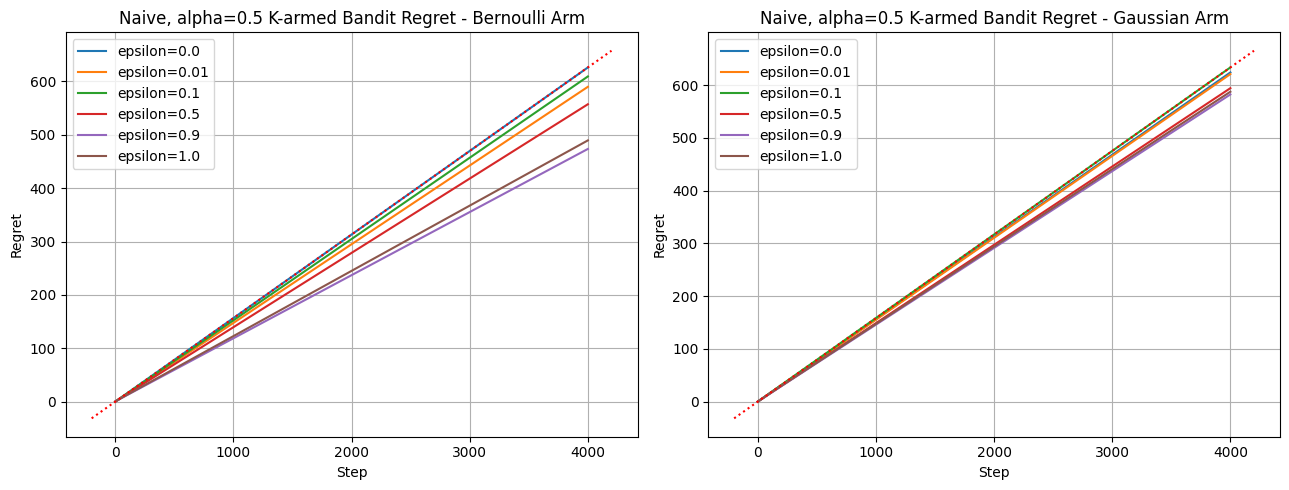

In [41]:
plt.figure(figsize=(13, 5))

plt.subplot(121)
plot_results(mab_bern_half, model="mab", arm="Bernoulli", columns='regret', title="Naive, alpha=0.5")

plt.subplot(122)
plot_results(mab_gaus_half, model="mab", arm="Gaussian", columns='regret', title="Naive, alpha=0.5")

plt.tight_layout()
plt.show()

## Optimistic Multi-Armed Bandit

### $\alpha$=1

In [42]:
mab_opt_bern_1 = procedure(fname="./eGreedyMAB_BernoulliArm_1.0_Optimistic_results.pkl", no_param=False)
mab_opt_gaus_1 = procedure(fname="./eGreedyMAB_GaussianArm_1.0_Optimistic_results.pkl", no_param=False)

getregret(mab_opt_bern_1)
getregret(mab_opt_gaus_1)

100%|██████████████████████████████████████████████████████████████████████████| 6/6 [00:30<00:00,  5.15s/it]


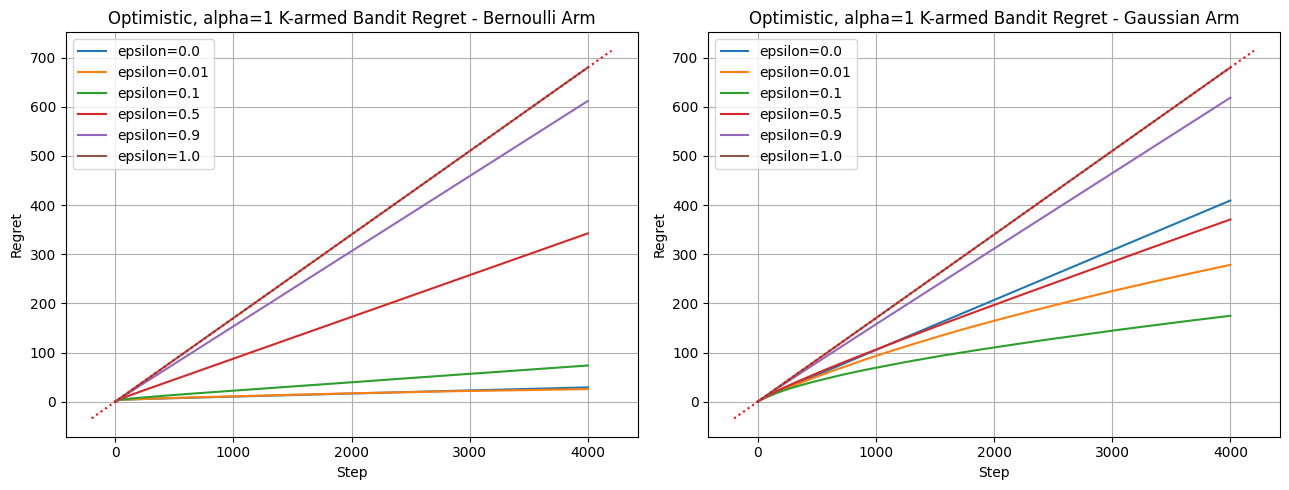

In [43]:
plt.figure(figsize=(13, 5))

plt.subplot(121)
plot_results(mab_opt_bern_1, model="mab", arm="Bernoulli", columns='regret', title="Optimistic, alpha=1")

plt.subplot(122)
plot_results(mab_opt_gaus_1, model="mab", arm="Gaussian", columns='regret', title="Optimistic, alpha=1")

plt.tight_layout()
plt.show()

### $\alpha$=0.5

In [44]:
mab_opt_bern_half = procedure(fname="./eGreedyMAB_BernoulliArm_0.5_Optimistic_results.pkl", no_param=False)
mab_opt_gaus_half = procedure(fname="./eGreedyMAB_GaussianArm_0.5_Optimistic_results.pkl", no_param=False)

getregret(mab_opt_bern_half)
getregret(mab_opt_gaus_half)

100%|██████████████████████████████████████████████████████████████████████████| 6/6 [00:31<00:00,  5.22s/it]


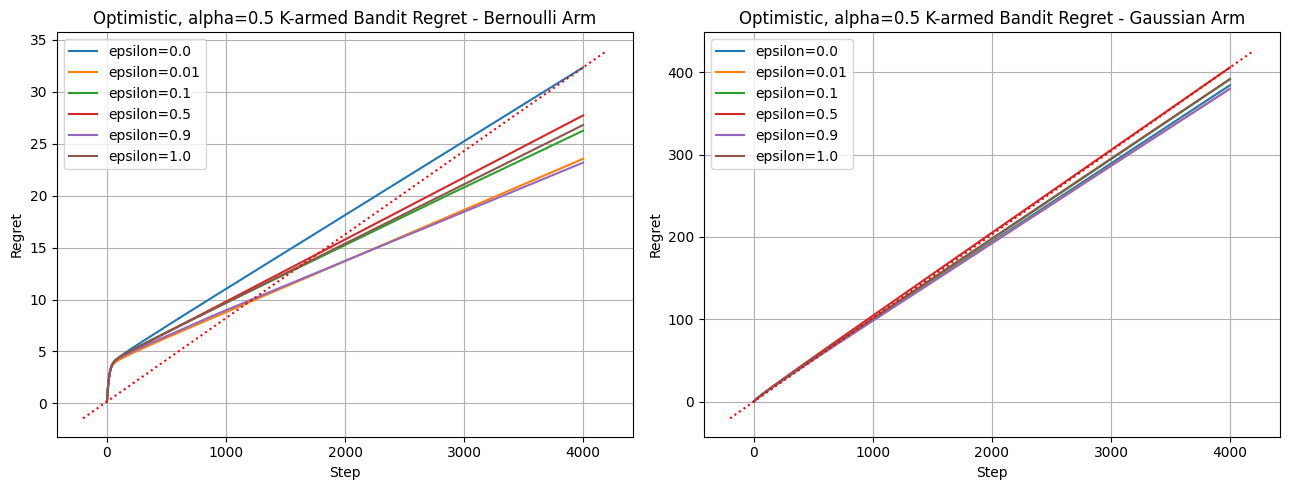

In [45]:
plt.figure(figsize=(13, 5))

plt.subplot(121)
plot_results(mab_opt_bern_half, model="mab", arm="Bernoulli", columns='regret', title="Optimistic, alpha=0.5")

plt.subplot(122)
plot_results(mab_opt_gaus_half, model="mab", arm="Gaussian", columns='regret', title="Optimistic, alpha=0.5")

plt.tight_layout()
plt.show()

## Naive vs Optimistic

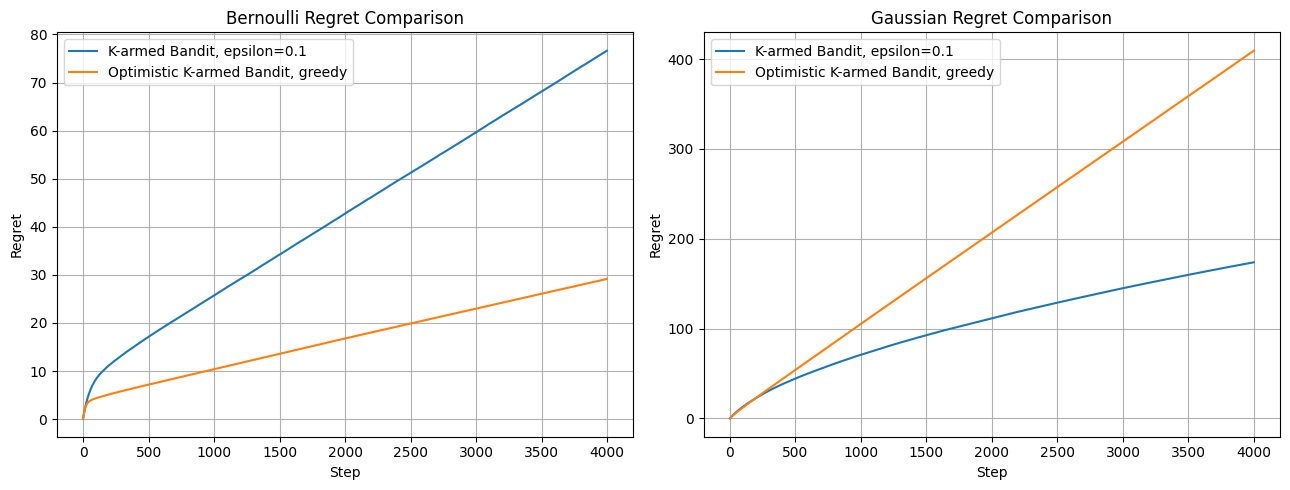

In [46]:
figsize = (13, 5)

model1, model2 = "mab", "mab"

column = 'regret'
ylabel = getlabel(column)

argmin1_col1, label1_col1 = summary(mab_bern_1, model1, column, greedy=False, is_optimistic=False, is_regret=True)
argmin2_col1, label2_col1 = summary(mab_opt_bern_1, model2, column, greedy=True, is_optimistic=True, is_regret=True)

argmin1_col2, label1_col2 = summary(mab_gaus_1, model1, column, greedy=False, is_optimistic=False, is_regret=True)
argmin2_col2, label2_col2 = summary(mab_opt_gaus_1, model2, column, greedy=True, is_optimistic=True, is_regret=True)

plt.figure(figsize=figsize)

plt.subplot(121)
plt.plot(mab_bern_1[argmin1_col1][column], label=label1_col1)
plt.plot(mab_opt_bern_1[argmin2_col1][column], label=label2_col1)
plt.grid(True)
plt.xlabel("Step")
plt.ylabel(ylabel)
plt.legend()
plt.title(f"Bernoulli {ylabel} Comparison")

plt.subplot(122)
plt.plot(mab_gaus_1[argmin1_col2][column], label=label1_col2)
plt.plot(mab_opt_gaus_1[argmin2_col2][column], label=label2_col2)
plt.grid(True)
plt.xlabel("Step")
plt.ylabel(ylabel)
plt.legend()
plt.title(f"Gaussian {ylabel} Comparison")

plt.tight_layout()
plt.show()

## Explore-then-Commit

In [47]:
etc_bern_1 = procedure(fname="./ETC_BernoulliArm_1.0_Naive_results.pkl", no_param=False)
etc_gaus_1 = procedure(fname="./ETC_GaussianArm_1.0_Naive_results.pkl", no_param=False)

getregret(etc_bern_1)
getregret(etc_gaus_1)

100%|██████████████████████████████████████████████████████████████████████████| 4/4 [00:21<00:00,  5.29s/it]


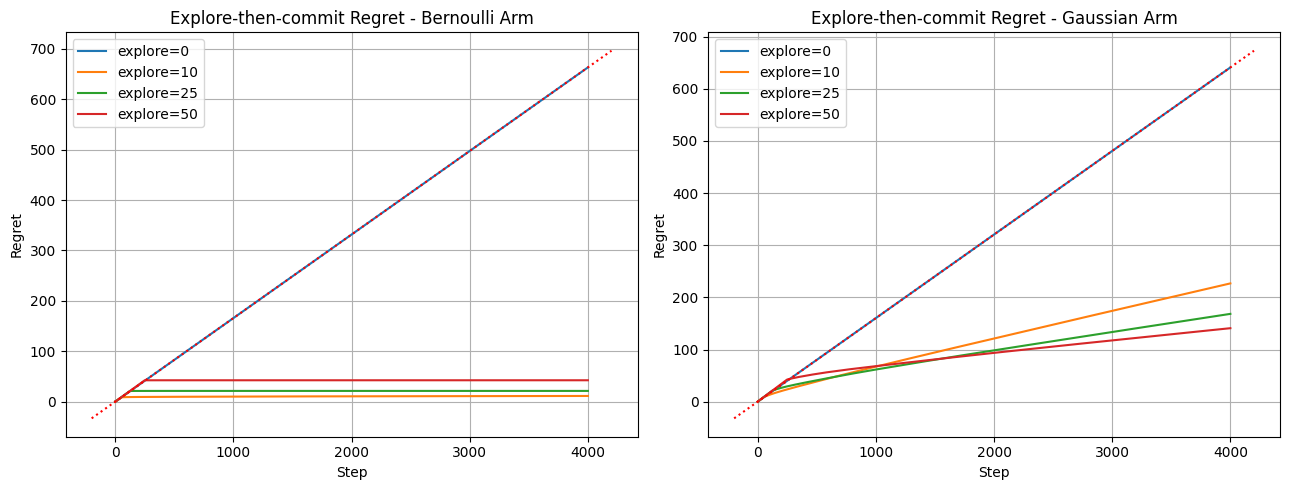

In [48]:
plt.figure(figsize=(13, 5))

plt.subplot(121)
plot_results(etc_bern_1, model="etc", arm="Bernoulli", columns='regret')

plt.subplot(122)
plot_results(etc_gaus_1, model="etc", arm="Gaussian", columns='regret')

plt.tight_layout()
plt.show()

## Thompson Sampling

In [49]:
ts_bern = procedure(fname="./ThompsonSampling_BernoulliArm_1.0_Naive_results.pkl", no_param=True)
ts_gaus = procedure(fname="./ThompsonSampling_GaussianArm_1.0_Naive_results.pkl", no_param=True)

getregret(ts_bern)
getregret(ts_gaus)

100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.05s/it]


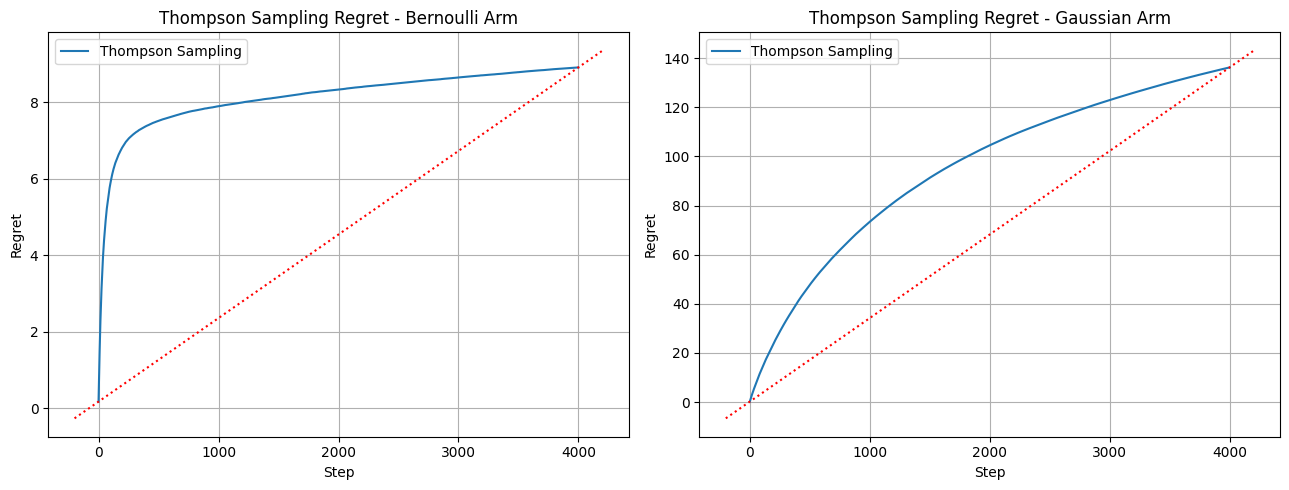

In [50]:
plt.figure(figsize=(13, 5))

plt.subplot(121)
plot_results(ts_bern, model="thompson", arm="Bernoulli", columns='regret')

plt.subplot(122)
plot_results(ts_gaus, model="thompson", arm="Gaussian", columns='regret')

plt.tight_layout()
plt.show()

## UCB

### Naive

In [51]:
ucbnaive_bern_1 = procedure(fname="./UCBNaive_BernoulliArm_1.0_Naive_results.pkl", no_param=False)
ucbnaive_gaus_1 = procedure(fname="./UCBNaive_GaussianArm_1.0_Naive_results.pkl", no_param=False)

getregret(ucbnaive_bern_1)
getregret(ucbnaive_gaus_1)

100%|██████████████████████████████████████████████████████████████████████████| 5/5 [00:26<00:00,  5.27s/it]


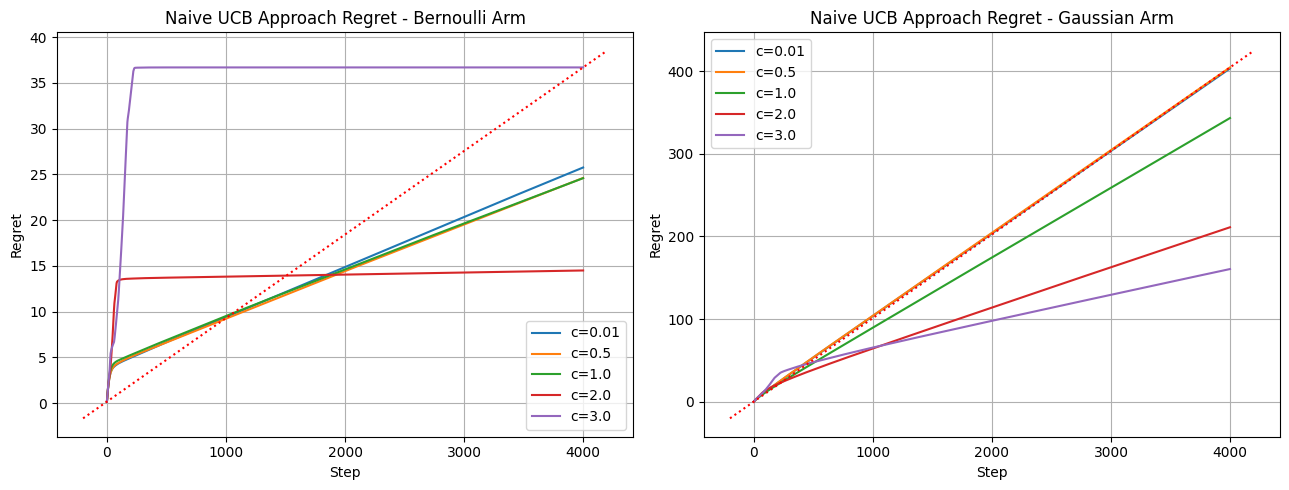

In [52]:
plt.figure(figsize=(13, 5))

plt.subplot(121)
plot_results(ucbnaive_bern_1, model="ucbnaive", arm="Bernoulli", columns='regret')

plt.subplot(122)
plot_results(ucbnaive_gaus_1, model="ucbnaive", arm="Gaussian", columns='regret')

plt.tight_layout()
plt.show()

### Delta

In [53]:
ucbdelta_bern_1 = procedure(fname="./UCBDelta_BernoulliArm_1.0_Naive_results.pkl", no_param=False)
ucbdelta_gaus_1 = procedure(fname="./UCBDelta_GaussianArm_1.0_Naive_results.pkl", no_param=False)

getregret(ucbdelta_bern_1)
getregret(ucbdelta_gaus_1)

100%|██████████████████████████████████████████████████████████████████████████| 6/6 [00:30<00:00,  5.13s/it]


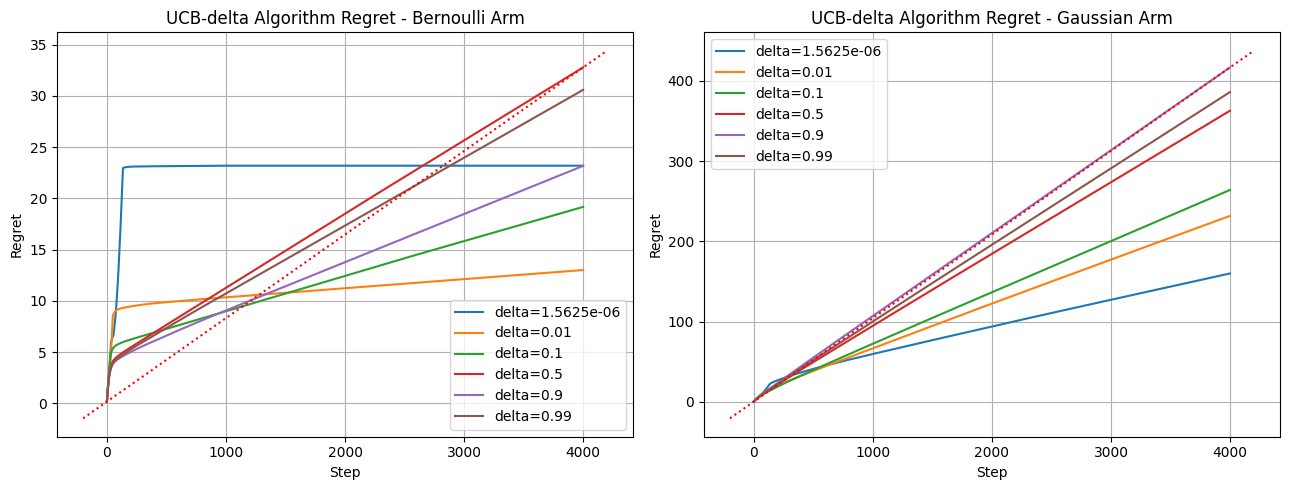

In [54]:
plt.figure(figsize=(13, 5))

plt.subplot(121)
plot_results(ucbdelta_bern_1, model="ucbdelta", arm="Bernoulli", columns='regret')

plt.subplot(122)
plot_results(ucbdelta_gaus_1, model="ucbdelta", arm="Gaussian", columns='regret')

plt.tight_layout()
plt.show()

### Asymptotically Optimal

In [55]:
ucbasym_bern_1 = procedure(fname="./UCBAsymptotic_BernoulliArm_1.0_Naive_results.pkl", no_param=True)
ucbasym_gaus_1 = procedure(fname="./UCBAsymptotic_GaussianArm_1.0_Naive_results.pkl", no_param=True)

getregret(ucbasym_bern_1)
getregret(ucbasym_gaus_1)

100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.90s/it]


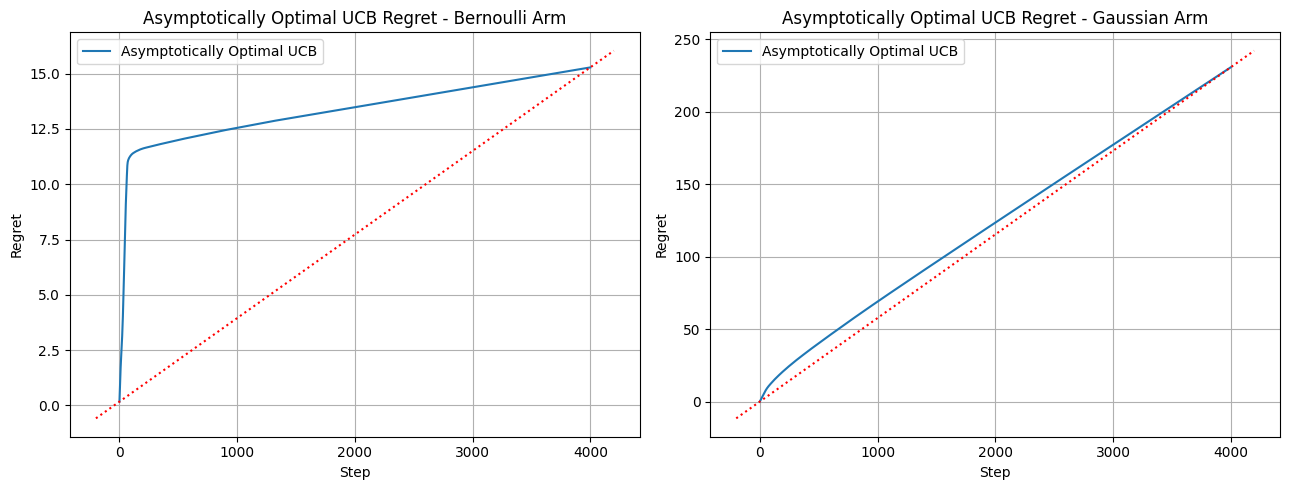

In [56]:
plt.figure(figsize=(13, 5))

plt.subplot(121)
plot_results(ucbasym_bern_1, model="ucbasym", arm="Bernoulli", columns='regret')

plt.subplot(122)
plot_results(ucbasym_gaus_1, model="ucbasym", arm="Gaussian", columns='regret')

plt.tight_layout()
plt.show()

### MOSS

In [57]:
ucbmoss_bern_1 = procedure(fname="./UCBMOSS_BernoulliArm_1.0_Naive_results.pkl", no_param=True)
ucbmoss_gaus_1 = procedure(fname="./UCBMOSS_GaussianArm_1.0_Naive_results.pkl", no_param=True)

getregret(ucbmoss_bern_1)
getregret(ucbmoss_gaus_1)

100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.85s/it]


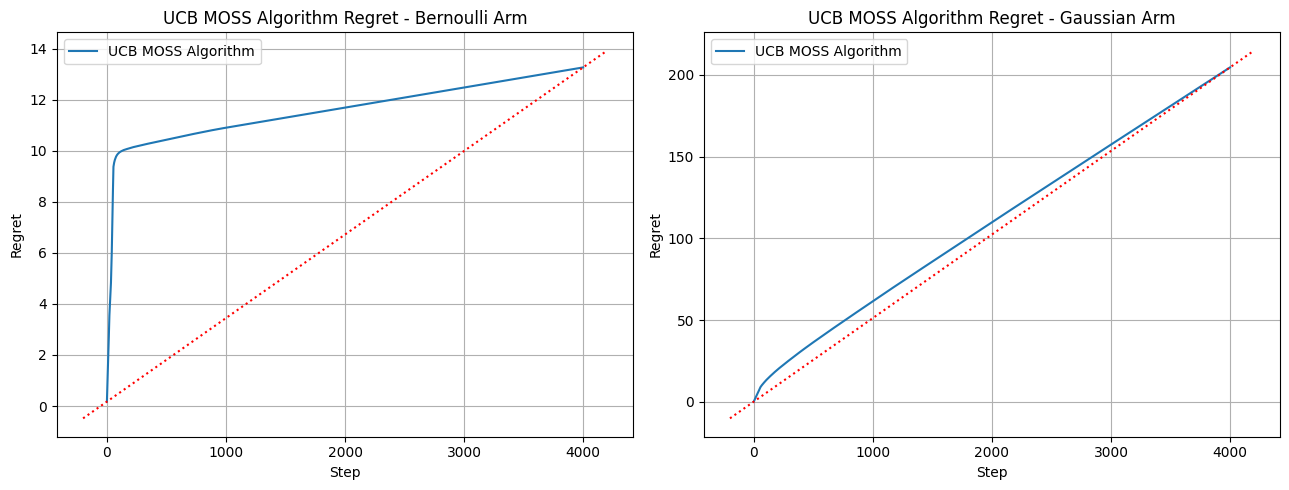

In [58]:
plt.figure(figsize=(13, 5))

plt.subplot(121)
plot_results(ucbmoss_bern_1, model="ucbmoss", arm="Bernoulli", columns='regret')

plt.subplot(122)
plot_results(ucbmoss_gaus_1, model="ucbmoss", arm="Gaussian", columns='regret')

plt.tight_layout()
plt.show()

### UCB Comparison

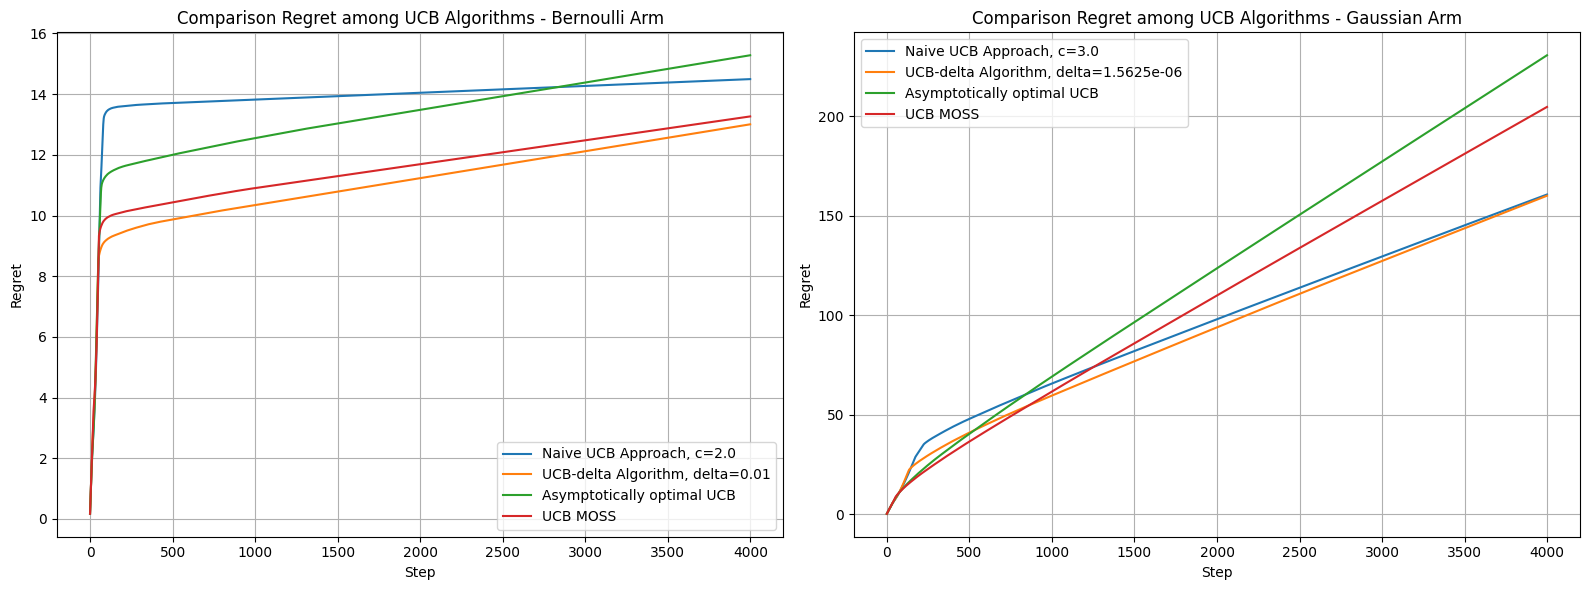

In [59]:
column = 'regret'
label = getlabel(column)

## find the best confidence term - naive approach
argmin_bern, label_bern = summary(ucbnaive_bern_1, "ucbnaive", column, greedy=False, is_optimistic=False, is_regret=True)
argmin_gaus, label_gaus = summary(ucbnaive_gaus_1, "ucbnaive", column, greedy=False, is_optimistic=False, is_regret=True)

## find the best delta
argmin_bern_delta, label_bern_delta = summary(ucbdelta_bern_1, "ucbdelta", column, greedy=False, is_optimistic=False, is_regret=True)
argmin_gaus_delta, label_gaus_delta = summary(ucbdelta_gaus_1, "ucbdelta", column, greedy=False, is_optimistic=False, is_regret=True)

naive_best_epsilon_bern = ucbnaive_bern_1[argmin_bern]['param'].iloc[0]
delta_best_epsilon_bern = ucbdelta_bern_1[argmin_bern_delta]['param'].iloc[0]

naive_best_epsilon_gaus = ucbnaive_gaus_1[argmin_gaus]['param'].iloc[0]
delta_best_epsilon_gaus = ucbdelta_gaus_1[argmin_gaus_delta]['param'].iloc[0]

figsize=(16, 6)
plt.figure(figsize=figsize)

plt.subplot(121)
plt.plot(ucbnaive_bern_1[argmin_bern][column], label=label_bern)
plt.plot(ucbdelta_bern_1[argmin_bern_delta][column], label=label_bern_delta)
plt.plot(ucbasym_bern_1[0][column], label=f"Asymptotically optimal UCB")
plt.plot(ucbmoss_bern_1[0][column], label=f"UCB MOSS")
plt.grid(True)
plt.xlabel("Step")
plt.ylabel(label)
plt.legend()
plt.title(f"Comparison {label} among UCB Algorithms - Bernoulli Arm")

plt.subplot(122)
plt.plot(ucbnaive_gaus_1[argmin_gaus][column], label=label_gaus)
plt.plot(ucbdelta_gaus_1[argmin_gaus_delta][column], label=label_gaus_delta)
plt.plot(ucbasym_gaus_1[0][column], label=f"Asymptotically optimal UCB")
plt.plot(ucbmoss_gaus_1[0][column], label=f"UCB MOSS")
plt.grid(True)
plt.xlabel("Step")
plt.ylabel(label)
plt.legend()
plt.title(f"Comparison {label} among UCB Algorithms - Gaussian Arm")

plt.tight_layout()
plt.show()

## Comparison Among Algorithms

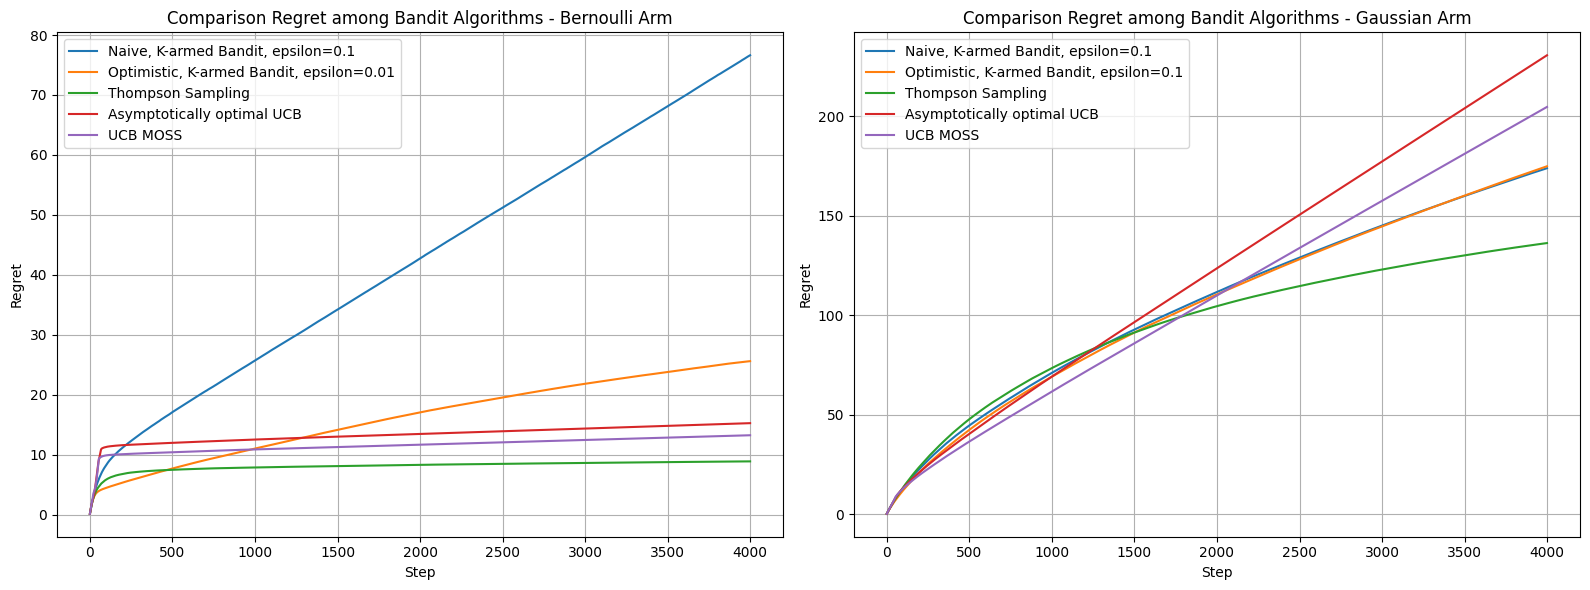

In [60]:
column = 'regret'
label = getlabel(column)

## find the best epsilon - naive approach
naive_mab_argmin_bern, naive_mab_label_bern = summary(mab_bern_1, "mab", column, greedy=False, is_optimistic=False, is_regret=True)
naive_mab_argmin_gaus, naive_mab_label_gaus = summary(mab_gaus_1, "mab", column, greedy=False, is_optimistic=False, is_regret=True)

## find the best epsilon - optimistic approach
opt_mab_argmin_bern, opt_mab_label_bern = summary(mab_opt_bern_1, "mab", column, greedy=False, is_optimistic=False, is_regret=True)
opt_mab_argmin_gaus, opt_mab_label_gaus = summary(mab_opt_gaus_1, "mab", column, greedy=False, is_optimistic=False, is_regret=True)

naive_best_epsilon_bern = mab_bern_1[naive_mab_argmin_bern]['param'].iloc[0]
naive_best_epsilon_gaus = mab_gaus_1[naive_mab_argmin_gaus]['param'].iloc[0]

opt_best_epsilon_bern = mab_opt_bern_1[opt_mab_argmin_bern]['param'].iloc[0]
opt_best_epsilon_gaus = mab_opt_gaus_1[opt_mab_argmin_gaus]['param'].iloc[0]

figsize=(16, 6)
plt.figure(figsize=figsize)

plt.subplot(121)
plt.plot(mab_bern_1[naive_mab_argmin_bern][column], label=f"Naive, {naive_mab_label_bern}")
plt.plot(mab_opt_bern_1[opt_mab_argmin_bern][column], label=f"Optimistic, {opt_mab_label_bern}")
plt.plot(ts_bern[0][column], label=f"Thompson Sampling")
plt.plot(ucbasym_bern_1[0][column], label=f"Asymptotically optimal UCB")
plt.plot(ucbmoss_bern_1[0][column], label=f"UCB MOSS")
plt.grid(True)
plt.xlabel("Step")
plt.ylabel(label)
plt.legend()
plt.title(f"Comparison {label} among Bandit Algorithms - Bernoulli Arm")

plt.subplot(122)
plt.plot(mab_gaus_1[naive_mab_argmin_gaus][column], label=f"Naive, {naive_mab_label_gaus}")
plt.plot(mab_opt_gaus_1[opt_mab_argmin_gaus][column], label=f"Optimistic, {opt_mab_label_gaus}")
plt.plot(ts_gaus[0][column], label=f"Thompson Sampling")
plt.plot(ucbasym_gaus_1[0][column], label=f"Asymptotically optimal UCB")
plt.plot(ucbmoss_gaus_1[0][column], label=f"UCB MOSS")
plt.grid(True)
plt.xlabel("Step")
plt.ylabel(label)
plt.legend()
plt.title(f"Comparison {label} among Bandit Algorithms - Gaussian Arm")

plt.tight_layout()
plt.show()